# 13 - ANÁLISIS CON XGB REGRESSOR

## IMPORTACIÓN DE PAQUETES

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.linear_model import PoissonRegressor
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#Métricas de evaluación
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#Crear Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

import cloudpickle

## IMPORTAR LOS DATOS

### CARGAR LOS DATOS

In [2]:
df = pd.read_pickle('../../02_Datos/03_Trabajo/df_final.pickle')
df.head()

,peso_yeo_mms,caballos_yeo_mms,aceleracion_yeo_mms,origen_1,any_modelo_73,any_modelo_80,any_modelo_70,colt,any_modelo_79,any_modelo_82,...,subaru,gl,concord,landau,corona,any_modelo_81,504,volvo,impala,mpg
0,0.755175,0.869861,0.248895,1.0,0.0,0.0,1.0,0,0.0,0.0,...,0,0,0,0,0,0.0,0,0,0,15.0
1,0.697145,0.826943,0.281928,1.0,0.0,0.0,1.0,0,0.0,0.0,...,0,0,0,0,0,0.0,0,0,0,16.0
2,0.878469,0.944816,0.146330,1.0,0.0,0.0,1.0,0,0.0,0.0,...,0,0,0,0,0,0.0,0,0,0,15.0
3,0.880684,0.984192,0.074690,1.0,0.0,0.0,1.0,0,0.0,0.0,...,0,0,0,0,0,0.0,0,0,1,14.0
4,0.873496,0.975833,0.037754,1.0,0.0,0.0,1.0,0,0.0,0.0,...,0,0,0,0,0,0.0,0,0,0,14.0


### SEPARAR PREDICTORAS Y TARGET

In [3]:
x = df.drop(columns='mpg').copy()
y = df.mpg.copy()

In [4]:
y.head(5)

0    15.0
1    16.0
2    15.0
3    14.0
4    14.0
Name: mpg, dtype: float64

In [5]:
print(x.shape)
print(y.shape)

(279, 37)
(279,)


In [6]:
x_columns = list(x.columns)
y_target = y.name

## MODELIZAR

### RESERVAR EL DATASET DE VALIDACIÓN

In [7]:
train_x, val_x, train_y, val_y = train_test_split(x, y, test_size= 0.3, random_state= 42)

### CREAR PIPE Y EL DICCIONARIO CON LOS ALGORITMOS, PARÁMETROS Y VALORES

Optimizamos los algoritmos, parámetros y valores para los mejores modelos analizados en el lazypredict

#### Parámetros a testear:

In [8]:
pipe = Pipeline([('algoritmo', XGBRegressor())])

grid = [   {
            'algoritmo__n_estimators': [100, 200, 300],
            'algoritmo__learning_rate': [0.01, 0.1, 0.2],
            'algoritmo__max_depth': [3, 4, 5],
            'algoritmo__subsample': [0.8, 0.9, 1.0],
            'algoritmo__colsample_bytree': [0.8, 0.9, 1.0],
            'algoritmo__reg_lambda': [0.1, 1, 10]  # Parámetro de regularización L2
            }
          ]

### OPTIMIZAR LOS HIPERPARÁMETROS

####  Con grid search

In [9]:
grid_search = GridSearchCV(estimator= pipe, 
                           param_grid = grid, 
                           cv = 5, 
                           scoring = 'neg_mean_absolute_percentage_error',
                           verbose = 0,
                           n_jobs = -1)

modelo = grid_search.fit(train_x,train_y)

pd.DataFrame(grid_search.cv_results_).sort_values(by = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algoritmo__colsample_bytree,param_algoritmo__learning_rate,param_algoritmo__max_depth,param_algoritmo__n_estimators,param_algoritmo__reg_lambda,param_algoritmo__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
81,0.120246,0.003332,0.009775,0.001466,0.8,0.1,3,100,0.1,0.8,"{'algoritmo__colsample_bytree': 0.8, 'algoritm...",-0.126877,-0.067275,-0.097699,-0.093336,-0.106549,-0.098347,0.019351,1
327,0.125888,0.009480,0.009574,0.000798,0.9,0.1,3,100,1,0.8,"{'algoritmo__colsample_bytree': 0.9, 'algoritm...",-0.120150,-0.064963,-0.100321,-0.111640,-0.101897,-0.099794,0.018828,2
84,0.117609,0.005707,0.009774,0.001716,0.8,0.1,3,100,1,0.8,"{'algoritmo__colsample_bytree': 0.8, 'algoritm...",-0.125266,-0.063485,-0.100035,-0.109928,-0.102736,-0.100290,0.020383,3
82,0.120085,0.004877,0.010173,0.000747,0.8,0.1,3,100,0.1,0.9,"{'algoritmo__colsample_bytree': 0.8, 'algoritm...",-0.130295,-0.069689,-0.098361,-0.099494,-0.106844,-0.100937,0.019401,4
324,0.119418,0.005978,0.009079,0.000204,0.9,0.1,3,100,0.1,0.8,"{'algoritmo__colsample_bytree': 0.9, 'algoritm...",-0.132483,-0.065237,-0.100868,-0.098698,-0.109598,-0.101377,0.021674,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,0.110628,0.010015,0.008977,0.000630,0.9,0.01,4,100,10,0.8,"{'algoritmo__colsample_bytree': 0.9, 'algoritm...",-0.360658,-0.397694,-0.398298,-0.379442,-0.406761,-0.388571,0.016560,725
303,0.108767,0.007046,0.009279,0.000866,0.9,0.01,5,100,10,0.8,"{'algoritmo__colsample_bytree': 0.9, 'algoritm...",-0.360658,-0.397694,-0.398396,-0.379442,-0.406761,-0.388590,0.016571,726
492,0.129765,0.011961,0.009779,0.000674,1.0,0.01,3,100,10,0.8,"{'algoritmo__colsample_bytree': 1.0, 'algoritm...",-0.360262,-0.397845,-0.397939,-0.381529,-0.406530,-0.388821,0.016413,727
519,0.116981,0.010458,0.010780,0.001586,1.0,0.01,4,100,10,0.8,"{'algoritmo__colsample_bytree': 1.0, 'algoritm...",-0.360262,-0.397845,-0.398128,-0.381529,-0.406530,-0.388859,0.016434,728


In [10]:
modelo.best_estimator_

Pipeline(steps=[('algoritmo',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.8, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

In [11]:
modelo.best_params_

{'algoritmo__colsample_bytree': 0.8,
 'algoritmo__learning_rate': 0.1,
 'algoritmo__max_depth': 3,
 'algoritmo__n_estimators': 100,
 'algoritmo__reg_lambda': 0.1,
 'algoritmo__subsample': 0.8}

In [12]:
modelo.best_score_

-0.09834706351636516

### CREAR PICKLE DE MODELO.BEST_ESTIMATOR y PARÁMETROS

In [13]:
modelo_best_estimator = modelo

#### Guardamos modelo, parámetros y score

In [14]:
m_best_estimator = str(modelo.best_estimator_[0])
m_best_estimator = m_best_estimator.split('(')[0]
m_best_params = str(modelo.best_params_)
m_best_score = str(modelo.best_score_)

## EVALUAR

### EVALUAR SOBRE EL TRAIN

In [15]:
pred = modelo.best_estimator_.predict(train_x)
t_mape = mean_absolute_percentage_error(train_y, pred)
t_coef_determinacion = r2_score(train_y,pred)
t_mae = mean_absolute_error(train_y, pred)
t_rmse =  mean_squared_error(train_y,pred,squared='False')

print("%mape:", t_mape )
print("Coeficiente de determinación:", t_coef_determinacion)
print("MAE:", t_mae)
print("RMSE:",t_rmse)


%mape: 0.046061256247883056
Coeficiente de determinación: 0.9750687742997274
MAE: 0.9869250243749372
RMSE: 1.5183759385323257


### PREDECIR SOBRE LA VALIDACIÓN

In [16]:
pred = modelo.best_estimator_.predict(val_x)

### EVALUAR SOBRE LA VALIDACIÓN

In [17]:
v_mape = mean_absolute_percentage_error(val_y, pred)
v_coef_determinacion = r2_score(val_y,pred)
v_mae = mean_absolute_error(val_y, pred)
v_rmse =  mean_squared_error(val_y,pred,squared='False')


print("%mape:", v_mape)
print("Coeficiente de determinación:", v_coef_determinacion)
print("MAE:", v_mae)
print("RMSE:", v_rmse)

%mape: 0.10347982529136608
Coeficiente de determinación: 0.7854291831016502
MAE: 2.3449712140219554
RMSE: 12.100731862376128


#### Gráfico entre la diferencia entre la validación y el original

In [18]:
test_y = val_y.reset_index().copy()
test_pred = pd.Series(pred).to_frame()
df_pred = pd.concat([test_y,test_pred], axis= 1).sort_values(by='mpg').reset_index()
df_pred.rename(columns = {0:'pred'}, inplace = True)
df_pred = df_pred.drop(columns= ['level_0'])
df_pred['dif'] = abs(df_pred['mpg']-df_pred['pred'])
# Diferencia entre predicción y validación
df_pred.sort_values(by = 'dif', ascending = False).head(10)

,index,mpg,pred,dif
83,231,43.4,28.769905,14.630095
81,271,38.0,25.539650,12.460350
72,236,32.7,22.266655,10.433345
47,237,23.7,33.884846,10.184846
76,261,34.0,27.870913,6.129087
36,258,20.2,25.903500,5.703500
20,259,17.6,22.843191,5.243191
75,234,33.8,38.705540,4.905540
32,194,19.8,24.001799,4.201799
10,86,15.0,19.195095,4.195095


- Quitaremos estos atípicos para mejor el modelo (index 85 y 273)

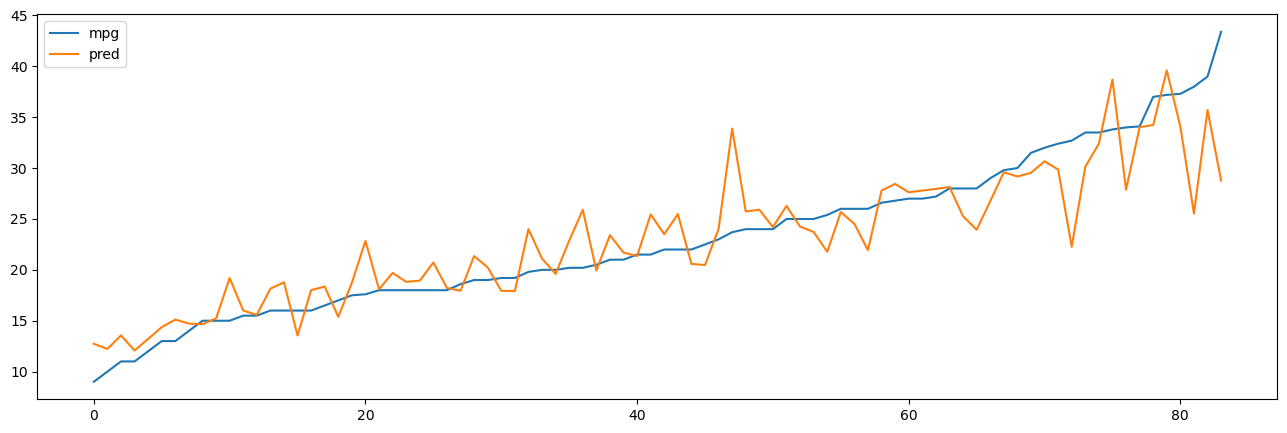

In [19]:
df_pred[['mpg','pred']].plot(figsize=(16,5));

## Gráficios de validación modelos de regresión

1. Gráfico de dispersión de valores reales vs. valores predichos: 

Este gráfico muestra los puntos de datos observados en un diagrama de dispersión, y superpone la línea de regresión que representa la relación lineal ajustada por el modelo. Puedes utilizar este gráfico para evaluar visualmente cómo se ajusta la línea de regresión a los datos observados.

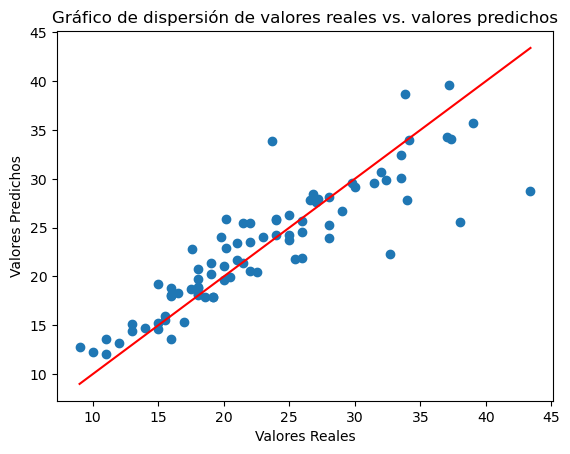

In [20]:
import matplotlib.pyplot as plt

# y = target: Valores reales
# pred - predicción: Valores predichos por el modelo

plt.scatter(val_y, pred)
plt.plot([min(val_y), max(val_y)], [min(val_y), max(val_y)], color='red')  # Línea diagonal
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Gráfico de dispersión de valores reales vs. valores predichos')
plt.show()


2. Gráfico de residuos vs. valores predichos: 


Un gráfico de residuos muestra los residuos (diferencias entre los valores observados y los valores predichos por el modelo) en función de los valores ajustados o las variables independientes. Este gráfico puede ayudarte a verificar si los residuos tienen algún patrón sistemático, como una relación no lineal o una heterocedasticidad.

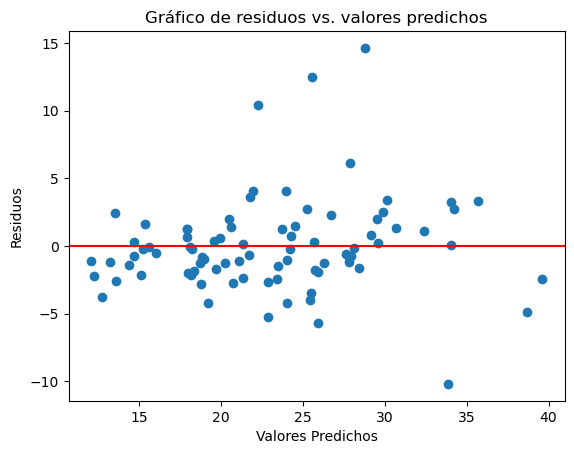

In [21]:
residuos = val_y - pred

plt.scatter(pred, residuos)
plt.axhline(y=0, color='red')  # Línea horizontal en cero
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.title('Gráfico de residuos vs. valores predichos')
plt.show()


3. Histograma de residuos:

 Este gráfico muestra la distribución de los residuos del modelo. Puedes utilizar un histograma o un gráfico de densidad para visualizar cómo se distribuyen los residuos y verificar si siguen una distribución aproximadamente normal.

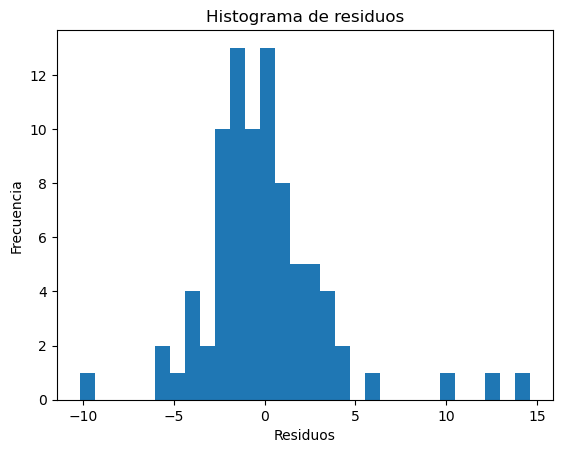

In [22]:
plt.hist(residuos, bins=30)
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.title('Histograma de residuos')
plt.show()

4. Gráfico de Q-Q (cuantil-cuantil):

Este gráfico compara los cuantiles de los residuos con los cuantiles esperados de una distribución normal. Puede ayudarte a evaluar si los residuos siguen una distribución normal.

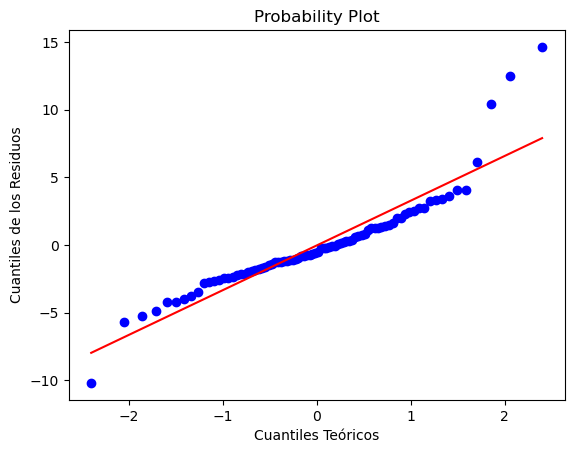

In [23]:
import scipy.stats as stats

stats.probplot(residuos, dist="norm", plot=plt)
plt.xlabel('Cuantiles Teóricos')
plt.ylabel('Cuantiles de los Residuos')
plt.show()


5. Gráfico de influencia:

Un gráfico de influencia muestra la influencia de cada observación en el ajuste del modelo. Puede ayudarte a identificar puntos atípicos o valores influyentes que pueden tener un impacto significativo en los resultados de la regresión.

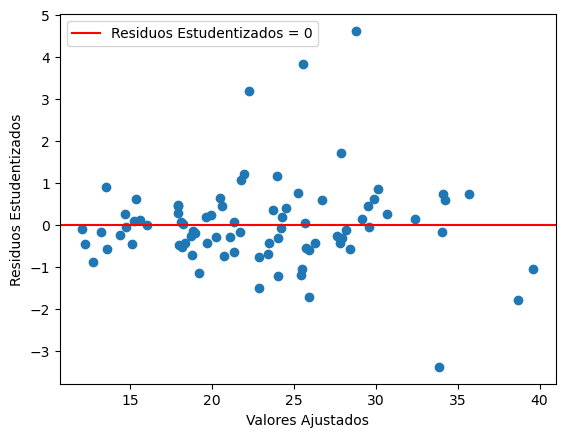

In [24]:
import statsmodels.api as sm

infl = sm.OLS(val_y, sm.add_constant(pred)).fit().get_influence()
residuos_estudentizados = infl.resid_studentized_external

plt.scatter(pred, residuos_estudentizados)
plt.axhline(y=0, color='r', linestyle='-', label='Residuos Estudentizados = 0')
plt.xlabel('Valores Ajustados')
plt.ylabel('Residuos Estudentizados')
plt.legend()
plt.show()

In [25]:
# Paso 3: Definir umbral para Valores Atípicos
std_dev_threshold = 2  # Umbral en desviaciones estándar

# Paso 4: Identificación de Atípicos
outliers_indices = np.where(np.abs(residuos) > std_dev_threshold * np.std(residuos))[0]
outliers_indices

array([ 5, 12, 37, 49], dtype=int64)

In [26]:
val_y.iloc[3]

20.0

# GUARDAR BEST_ESTIMATOR, PARÁMETROS Y RESULTADOS DEL TEST Y LA VALIDACIÓN

#### Guardar el mejor estimador

In [27]:
version_estimator = 'v7_'
nombre_best_estimator = version_estimator + m_best_estimator +  '.pickle'
nombre_best_estimator

'v7_XGBRegressor.pickle'

In [28]:
m_best_estimator

'XGBRegressor'

In [29]:
ruta_pipe_entrenamiento = '../../04_Modelos/Best_estimator/' + nombre_best_estimator

with open (ruta_pipe_entrenamiento, mode= 'wb') as file:
    cloudpickle.dump(modelo_best_estimator, file)


### Guardar la información del estimador

In [30]:
# Añadir comentarios sobre el modelo

comentarios = "Cambiamos de modelo al XGBRegressor con hiperparámetros para evitar el sobre ajuste "


In [31]:
#Cargamos la lista con los resultados
resultado  = {'m_Best_estimator': m_best_estimator,
               'm_Best_paramans' : m_best_params,
               'm_Best_Score': m_best_score, 
               't_%mape': t_mape, 
               't_Coef._determinacion': t_coef_determinacion, 
               't_mae': t_mae, 
               't_rmse': t_rmse, 
               'v_%mape':  v_mape, 
               'v_Coef._determinacion': v_coef_determinacion, 
               'v_mae': v_mae, 
               'v_rmse': v_rmse,
               'comentarios': comentarios,
               'predictoras_X': x_columns,
               'target_y': y_target
            }
resultado= pd.Series(resultado,name=nombre_best_estimator)
resultado

m_Best_estimator                                              XGBRegressor
m_Best_paramans          {'algoritmo__colsample_bytree': 0.8, 'algoritm...
m_Best_Score                                          -0.09834706351636516
t_%mape                                                           0.046061
t_Coef._determinacion                                             0.975069
t_mae                                                             0.986925
t_rmse                                                            1.518376
v_%mape                                                            0.10348
v_Coef._determinacion                                             0.785429
v_mae                                                             2.344971
v_rmse                                                           12.100732
comentarios              Cambiamos de modelo al XGBRegressor con hiperp...
predictoras_X            [peso_yeo_mms, caballos_yeo_mms, aceleracion_y...
target_y                 

In [32]:
df_best = pd.read_excel('../../04_Modelos/Best_estimator/Best_estimator.xlsx',index_col=0)


In [33]:
df_best = pd.concat([df_best, resultado], ignore_index= False,axis=1)
df_best.to_excel('../../04_Modelos/Best_estimator/Best_estimator.xlsx')

## CONCLUSIÓN ## 

Tras analizar los diferentes modelos de predictivos. Nos quedaremos con el RidgeCV_v06.

**PRÓXIMOS PASOS:**

- Preparar datos de entrenamiento con todos los datos.
- Evaluar los datos de validación con el modelo definitivo.